In [2]:
import numpy
import matplotlib.pyplot
%matplotlib inline
import tensorflow
from tensorflow import keras

2023-04-06 14:45:00.360011: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-06 14:45:00.394616: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-06 14:45:00.395543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 14:45:00.899456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from tensorflow.keras.preprocessing.image import load_img

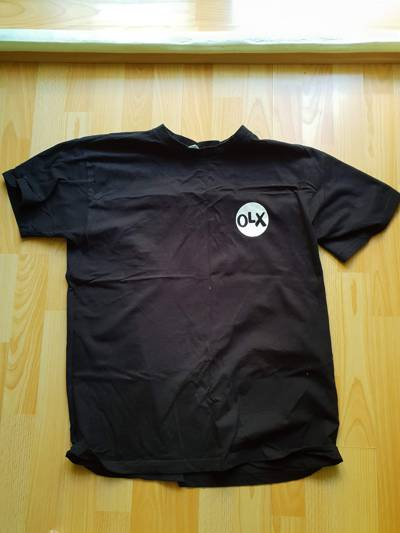

In [6]:
path = '/mlbc/clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = path + '/' + name
load_img(fullname)

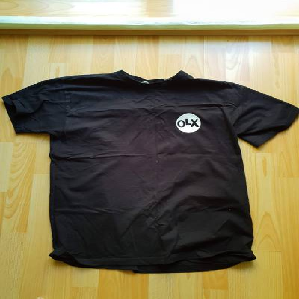

In [7]:
load_img(fullname, target_size=(299,299))

In [9]:
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions

In [10]:
# download the model and use it
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

91884032/91884032 [==============================] - 6s 0us/step


In [13]:
img = load_img(fullname, target_size=(299, 299))

In [15]:
# convert Image object to NumPy array
img_array = numpy.array(img)

img_array.shape # (width, height, channels [red/blue/green])

(299, 299, 3)

In [17]:
# create a one-image batch
img_batch = numpy.array([img_array])

img_batch.shape # (number of images, width, height, channels [red/blue/green])

(1, 299, 299, 3)

In [19]:
# utilize the preprocess method to prepare the image for usage with the model
img_batch_preprocessed = preprocess_input(img_batch)

# converts integers [0-255] to [-1, 1]

In [20]:
prediction = model.predict(img_batch_preprocessed)

prediction.shape # shape is not useful for humans

1/1 [==============================] - 1s 804ms/step


(1, 1000)

In [21]:
# can use the decoder to determine what the prediction is
decode_predictions(prediction)

35363/35363 [==============================] - 0s 0us/step


[[('n03595614', 'jersey', 0.68196315),
  ('n02916936', 'bulletproof_vest', 0.038140025),
  ('n04370456', 'sweatshirt', 0.03432483),
  ('n03710637', 'maillot', 0.011354222),
  ('n04525038', 'velvet', 0.001845362)]]

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# utilize Kera's data generator which will allow us to load images in small batches
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [23]:
train_dataset = train_generator.flow_from_directory("/mlbc/clothing-dataset-small/train",
                                                   target_size=(150,150),
                                                   batch_size=32)

# target size of 150 makes it faster to run, but less accurate

Found 3068 images belonging to 10 classes.


In [24]:
validation_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [25]:
validation_dataset = validation_generator.flow_from_directory("/mlbc/clothing-dataset-small/validation",
                                                             target_size=(150, 150),
                                                             batch_size=32)

Found 341 images belonging to 10 classes.


In [26]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150,150,3))
# include_top -> not interested in dense layers, only convolutional
# in Keras, input is on the bottom and output is on top, dense layers are the top layer

83683744/83683744 [==============================] - 6s 0us/step


In [27]:
# freeze the base model, prevent it from training
base_model.trainable = False

In [29]:
# build the model

# specify the size of the images
inputs = keras.Input(shape=(150,150,3))

# create the base model using the input parameters
# training=False tells not to train the base model
base = base_model(inputs, training=False)

# create a "pooling layer" - converts output of convoluted layer (3d) to a vector (1d)
# immediately invoke on the base model
vector = keras.layers.GlobalAveragePooling2D()(base)

# create a dense layer of 10 classes, connect it to our vector
outputs = keras.layers.Dense(10)(vector)

# wrap inputs and outputs into a Model class
new_model = keras.Model(inputs, outputs)

In [31]:
# utilize an optimizer (Adam)

learning_rate = 0.01 # how fast the network learns. higher is rougher and quicker

optimizer = keras.optimizers.Adam(learning_rate)

In [32]:
# optimizer uses a loss function to determine how well it is doing
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# from_logits -> newtowrk outputs raw scores (logits) not probabilities

In [34]:
# compile the model
new_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# train the model
new_model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

# epochs -> number of times to go over the data, more = more accurate
# validation_dataset -> prevents the model from overfitting

Epoch 1/10


2023-04-06 16:32:16.705144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


96/96 [==============================] - ETA: 0s - loss: 1.2838 - accuracy: 0.6708

2023-04-06 16:32:45.407356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


96/96 [==============================] - 32s 320ms/step - loss: 1.2838 - accuracy: 0.6708 - val_loss: 0.9416 - val_accuracy: 0.7361
Epoch 2/10
96/96 [==============================] - 30s 311ms/step - loss: 0.5054 - accuracy: 0.8416 - val_loss: 0.7603 - val_accuracy: 0.8035
Epoch 3/10
96/96 [==============================] - 30s 309ms/step - loss: 0.3178 - accuracy: 0.8807 - val_loss: 0.7492 - val_accuracy: 0.8006
Epoch 4/10
96/96 [==============================] - 30s 311ms/step - loss: 0.2759 - accuracy: 0.9012 - val_loss: 0.8822 - val_accuracy: 0.8094
Epoch 5/10
96/96 [==============================] - 30s 312ms/step - loss: 0.1565 - accuracy: 0.9475 - val_loss: 0.9511 - val_accuracy: 0.7947
Epoch 6/10
96/96 [==============================] - 30s 308ms/step - loss: 0.1503 - accuracy: 0.9446 - val_loss: 0.8725 - val_accuracy: 0.8094
Epoch 7/10
96/96 [==============================] - 30s 313ms/step - loss: 0.1154 - accuracy: 0.9599 - val_loss: 1.0649 - val_accuracy: 0.7625
Epoch 8/10

In [38]:
# create function for training the model
def make_model(learning_rate):
    shape=(150,150,3)
    base_model = Xception(weights='imagenet', input_shape=shape, include_top=False)
    base_model.trainable = False
    
    inputs = keras.Input(shape=shape)
    
    base = base_model(inputs, training=False)
    
    pooling = keras.layers.GlobalAveragePooling2D()
    vector = pooling(base)
    
    layer = keras.layers.Dense(10)
    outputs = layer(vector)
    
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate)
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    
    return model

def fit(model):
    model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

In [46]:
model_3 = make_model(learning_rate=0.001) # from 0.01 to 0.001
fit(model=model_3)

model_4 = make_model(learning_rate=0.0001) # from 0.001 to 0.0001
fit(model=model_4)

Epoch 1/10


2023-04-06 16:45:03.998653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


96/96 [==============================] - ETA: 0s - loss: 1.0984 - accuracy: 0.6105

2023-04-06 16:45:31.538002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


96/96 [==============================] - 31s 309ms/step - loss: 1.0984 - accuracy: 0.6105 - val_loss: 0.7296 - val_accuracy: 0.7713
Epoch 2/10
96/96 [==============================] - 29s 301ms/step - loss: 0.6398 - accuracy: 0.7771 - val_loss: 0.6408 - val_accuracy: 0.7859
Epoch 3/10
96/96 [==============================] - 28s 296ms/step - loss: 0.5217 - accuracy: 0.8266 - val_loss: 0.5965 - val_accuracy: 0.8094
Epoch 4/10
96/96 [==============================] - 29s 302ms/step - loss: 0.4299 - accuracy: 0.8693 - val_loss: 0.5731 - val_accuracy: 0.8094
Epoch 5/10
96/96 [==============================] - 29s 302ms/step - loss: 0.3727 - accuracy: 0.8885 - val_loss: 0.5582 - val_accuracy: 0.8035
Epoch 6/10
96/96 [==============================] - 29s 303ms/step - loss: 0.3298 - accuracy: 0.9035 - val_loss: 0.5378 - val_accuracy: 0.8211
Epoch 7/10
96/96 [==============================] - 29s 306ms/step - loss: 0.2932 - accuracy: 0.9188 - val_loss: 0.5566 - val_accuracy: 0.8006
Epoch 8/10

2023-04-06 16:49:56.979084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


96/96 [==============================] - ETA: 0s - loss: 2.0652 - accuracy: 0.3022

2023-04-06 16:50:24.542274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


96/96 [==============================] - 31s 309ms/step - loss: 2.0652 - accuracy: 0.3022 - val_loss: 1.7021 - val_accuracy: 0.4780
Epoch 2/10
96/96 [==============================] - 29s 301ms/step - loss: 1.4554 - accuracy: 0.5469 - val_loss: 1.3323 - val_accuracy: 0.6070
Epoch 3/10
96/96 [==============================] - 29s 301ms/step - loss: 1.1918 - accuracy: 0.6330 - val_loss: 1.1354 - val_accuracy: 0.6686
Epoch 4/10
96/96 [==============================] - 29s 301ms/step - loss: 1.0403 - accuracy: 0.6816 - val_loss: 1.0180 - val_accuracy: 0.6833
Epoch 5/10
96/96 [==============================] - 29s 304ms/step - loss: 0.9422 - accuracy: 0.7044 - val_loss: 0.9390 - val_accuracy: 0.7038
Epoch 6/10
96/96 [==============================] - 29s 302ms/step - loss: 0.8690 - accuracy: 0.7256 - val_loss: 0.8768 - val_accuracy: 0.7302
Epoch 7/10
96/96 [==============================] - 29s 303ms/step - loss: 0.8129 - accuracy: 0.7425 - val_loss: 0.8372 - val_accuracy: 0.7449
Epoch 8/10

In [47]:
# save the best model
model_4.save_weights("xception_v1_model.h5", save_format="h5")

# h5 -> format for saving binary data

In [48]:
# model checkpointing saves the model only if the next epoch is worse
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy")

def fit_save(model):
    model.fit(train_dataset,
              epochs=10,
              validation_data=validation_dataset, 
              callbacks=[checkpoint])

In [49]:
fit_save(model=model_4)

Epoch 1/10


2023-04-06 17:01:41.211471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


96/96 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.7859

2023-04-06 17:02:07.209617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


96/96 [==============================] - 29s 303ms/step - loss: 0.6692 - accuracy: 0.7859 - val_loss: 0.7296 - val_accuracy: 0.7595
Epoch 2/10
96/96 [==============================] - 29s 301ms/step - loss: 0.6461 - accuracy: 0.7947 - val_loss: 0.7140 - val_accuracy: 0.7683
Epoch 3/10
96/96 [==============================] - 29s 300ms/step - loss: 0.6229 - accuracy: 0.7992 - val_loss: 0.7003 - val_accuracy: 0.7683
Epoch 4/10
96/96 [==============================] - 29s 305ms/step - loss: 0.6017 - accuracy: 0.8061 - val_loss: 0.6870 - val_accuracy: 0.7830
Epoch 5/10
96/96 [==============================] - 29s 302ms/step - loss: 0.5831 - accuracy: 0.8093 - val_loss: 0.6755 - val_accuracy: 0.7918
Epoch 6/10
96/96 [==============================] - 29s 301ms/step - loss: 0.5664 - accuracy: 0.8152 - val_loss: 0.6635 - val_accuracy: 0.7977
Epoch 7/10
96/96 [==============================] - 29s 299ms/step - loss: 0.5502 - accuracy: 0.8207 - val_loss: 0.6585 - val_accuracy: 0.7977
Epoch 8/10

In [51]:
# we could add another layer of size 100
# this can be adjusted as another parameter
next_layer = keras.layers.Dense(100, activation="relu")(vector)

next_outputs = keras.layers.Dense(10)(next_layer)

model_5 = keras.Model(inputs, next_outputs)

In [52]:
# using dropout can prevent overfitting
drop = keras.layers.Dropout(0.2)(next_layer)
outputs_with_dropout = keras.layers.Dense(10)(drop)

model_6 = keras.Model(inputs, outputs_with_dropout)

In [53]:
def make_model_with_dropout(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )
 
    base_model.trainable = False
 
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
 
    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)
 
    outputs = keras.layers.Dense(10)(drop)
 
    model = keras.Model(inputs, outputs)
 
    optimizer = keras.optimizers.Adam(learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
   
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"],
    )
   
    return model

In [54]:
# augmenting images can increase the size of the dataset to improve training without
# actually needing to find more images

# keras has a utility for this
image_generator = ImageDataGenerator(rotation_range=30,
                                    width_shift_range=30.0,
                                    height_shift_range=30.0,
                                    shear_range=10.0,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=preprocess_input)

In [55]:
train_dataset_2 = image_generator.flow_from_directory("/mlbc/clothing-dataset-small/train",
                                                     target_size=(150,150),
                                                      batch_size=32)

Found 3068 images belonging to 10 classes.


In [56]:
validation_generator_2 = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_dataset_2 = validation_generator_2.flow_from_directory("/mlbc/clothing-dataset-small/validation",
                                                                 target_size=(150,150),
                                                                 batch_size=32)

Found 341 images belonging to 10 classes.


In [57]:
model_5 = make_model_with_dropout(learning_rate=0.001, droprate=0.2)

fit_save(model=model_5)

Epoch 1/10


2023-04-06 18:40:56.837992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


96/96 [==============================] - ETA: 0s - loss: 1.0553 - accuracy: 0.6450

2023-04-06 18:41:27.565958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


96/96 [==============================] - 34s 329ms/step - loss: 1.0553 - accuracy: 0.6450 - val_loss: 0.6432 - val_accuracy: 0.8035
Epoch 2/10
96/96 [==============================] - 31s 317ms/step - loss: 0.6289 - accuracy: 0.7813 - val_loss: 0.5941 - val_accuracy: 0.8065
Epoch 3/10
96/96 [==============================] - 31s 321ms/step - loss: 0.4799 - accuracy: 0.8370 - val_loss: 0.5558 - val_accuracy: 0.8299
Epoch 4/10
96/96 [==============================] - 31s 325ms/step - loss: 0.3693 - accuracy: 0.8794 - val_loss: 0.5414 - val_accuracy: 0.8387
Epoch 5/10
96/96 [==============================] - 31s 318ms/step - loss: 0.2972 - accuracy: 0.9016 - val_loss: 0.5335 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 30s 316ms/step - loss: 0.2399 - accuracy: 0.9218 - val_loss: 0.5462 - val_accuracy: 0.8358
Epoch 7/10
96/96 [==============================] - 30s 316ms/step - loss: 0.1707 - accuracy: 0.9475 - val_loss: 0.5300 - val_accuracy: 0.8299
Epoch 8/10